# Chapter 11-Tuning Hyperparameters and Pipelines

## Setup

In [2]:
#@title Files for Import
import_file = "mlwpy.py" #@param {type:"string"}

#import libraries
import re
import importlib

#create regex
find = re.compile(r"^(.*?)\..*")
# extract file name before .py ending
import_file_no_ext = re.search(find, import_file).group(1)

# copy file to the current notebook
!cp '/content/drive/MyDrive/Colab Notebooks/imports/{import_file}' .
# import module
module = importlib.import_module(import_file_no_ext)

# is there an __all__? if so import all
if '__all__' in module.__dict__:
    names = module.__dict__['__all__']
else:
    # otherwise import all names that don't begin with _
    names = [x for x in module.__dict__ if not x.startswith('_')]

# now bring them in
globals().update({k: getattr(module, k) for k in names})

print(f'Imported file: {import_file_no_ext}.py')

# set matplotlib to display inline
%matplotlib inline

Imported file: mlwpy.py


## CSS


In [21]:
# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Set font and figure sizes 

In [12]:
#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 5 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)

## Load datasets

In [3]:
iris      = datasets.load_iris()
diabetes  = datasets.load_diabetes()
digits    = datasets.load_digits()

## 11.1 Models, Parameters, Hyperparameters

There are many ways to build computers. The following function performs the same operation in the same way.

In [4]:
def add_three(x):
    return 3 + x

def add(x, y):
    return x + y

add(10,3)==add_three(10)     

True

We can either hard-code the value or pass it in at runtime. If a knob is on the side of the machine, we adjust that value when we fit a model. If it is *inside* the box, it is part of the fixed internal components of the machine.

In [6]:
def make_adder(k):
    def add_k(x):
        return x + k
    return add_k

# a call that creates a function
three_adder = make_adder(3)

# using that created function
three_adder(10) == add_three(10)

True

The good news is *it worked*. In line 7: `three_adder = make_adder(3)`, spins up the usual machinery of a function call. The `3` is associated with the name `k` in `make_adder`. We execute the code in `make_adder`. It does two things: defines the name `add_k`, with function *stuff*, and returns `add_k`. We are defining a name `add_k` whose value is a function, not just a simple `int`.

`add_k` is a function of one argument, `x`. Whatever value is passed into `add_k` will be added to the `k` value that was passed into `make_adder`. However, this particulary `add_k` *can never add anything else to x*. That `k` is a constant value for all time from its perspective. To get a different `add_k` we must make another call to `make_adder` and create a *different* function.

Let's summarize what we get from `make_adder`.

* The returned *thing* (strictly, it's a Python object), is a function with one argument.
* When the returned function is called, it (1) computes `k` plus the value it is called with and (2) returns that value.

When we say `KNeighborsClassifier(3)` we are doing something like `make_adder(3)`. It gives us a concrete object we can `.fit` that has a `3` baked into its recipe. 

What is the takeaway message? 

1. After we create a model, we don't modify the internal state of the learning machine. We can modify the values of the knobs and what we feed it with the side input tray.

2. The training step gives us the preferred knob settings and input-tray contents.

3. If we don't like the result of testing after training, we can select an entirely different learning machine with different internals. We could also choose machines that are of different types. This is the process of *model selection*.

## 11.2 Tuning Hyperparameters

Let's look at how we select good hyperparameters with `sklearn`.

### 11.2.1 A Note on Computer Science and Learning Terminology

### 11.2.2 An Example of Complete Search

`KNeighborsClassifier` has many arguments it can be called with, most are hyperparameters that control the internal operation of the `KNeighborsClassifier` we create.

In [7]:
knn = neighbors.KNeighborsClassifier()
print(' '.join(knn.get_params().keys()))

algorithm leaf_size metric metric_params n_jobs n_neighbors p weights


The `n_neighbors` argument controls the *k* in our *k*-NN learning model. A key issue with nearest neighbors is deciding distance, which is controlled by some combinations of `metric`, `metric_params`, and `p`. `weights` determines how the neighbors combine themselves to create a final answer.

#### 11.2.2.1 Evaluating a Single Hyperparameter

Let's use the built-in `sklearn` support from `GridSearch`.

In [8]:
param_grid = {'n_neighbors' : [1,3,5,10,20]}

knn = neighbors.KNeighborsClassifier()
# warning! this is with accuracy
grid_model = skms.GridSearchCV(knn,
                               return_train_score=True,
                               param_grid = param_grid,
                               cv=10)
grid_model.fit(digits.data, digits.target)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

The result of `skms.GridSearchCV` is *just a model,* so you know how to make it run: call `fit` on it. It will take about five times as long as a single *k*-NN run because we run it for five values of *k*. To convert the python dictionary that the `fit` method returns into a `DataFrame` we run `pd.DataFrame(grid_model.cv_results_).`

In [9]:
# many columns in .cv_results_
# all params are also available in 'params' column as dict
param_cols = ['param_n_neighbors']
score_cols = ['mean_train_score', 'std_train_score',
              'mean_test_score', 'std_test_score']

# look at first five params with head()
df = pd.DataFrame(grid_model.cv_results_).head()

display(df[param_cols + score_cols])

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,1.0000,0.0000,0.9750,0.0171
1,3,0.9933,0.0008,0.9766,0.0155
2,5,0.9905,0.0006,0.9711,0.0172
3,10,0.9857,0.0011,0.9622,0.0205
4,20,0.9807,0.0018,0.9588,0.0224


We can single out some columns of interest and index the `DataFrame` by the parameter we manipulated.

In [10]:
# subselect columns of interest:
# param_* is a bit verbose
grid_df = pd.DataFrame(grid_model.cv_results_,
                       columns=['param_n_neighbors',
                                'mean_train_score',
                                'mean_test_score'])
grid_df.set_index('param_n_neighbors', inplace=True)
display(grid_df)

,mean_train_score,mean_test_score
param_n_neighbors,,
1,1.0000,0.9750
3,0.9933,0.9766
5,0.9905,0.9711
10,0.9857,0.9622
20,0.9807,0.9588


Also, we can view this graphically.

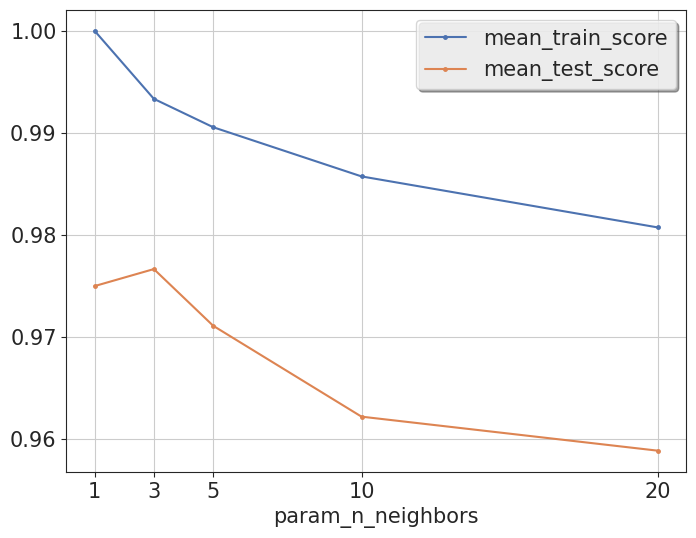

In [13]:
ax = grid_df.plot.line(marker='.')
ax.set_xticks(grid_df.index)

#### 11.2.2.2 Evaluating over Multiple Hyperparameters

The `n_neighbors` and `p` parameters are integers. We could try *lots* of different values for them. We need to manage training and test sets for all of these combinations. Otherwise, we put ourselves at risk to overfit the data with some particular hyperparameters because we never evaluated them on fresh data.

If we were to try that by hand for a model that takes three parameters, it might look like this in quick-and-dirty Pythonic pseudocode...

Let's say we want to try all combinations of these hyperparameters:

| **Hyperparameter** | **Values** |
| :--- | :--- | 
| `n_neighbors` | 1, ..., 10 |
| `weights` | *uniform, distance* |
| `p` | 1, 2, 4, 8, 16 |

1. *distance* means the my neighbor's contribution is weighted by its distance from *me*. *uniform* means all my neighbors are considered the same with no weighting.

2. `p` is an argument to a *Minkowski distance* constructor. We saw it briefly in Chapter 2. Just know that *p* = 1 is a Manhattan distance ($L_1$-like), *p* = 2 is Euclidean distance ($L_2$-like), and higher *p*s approach something called an infinity-norm.

The following performs the setup to try these possibilities for a *k*-NN model, not the actual processing.

In [18]:
param_grid = {'n_neighbors' : np.arange(1,11),
              'weights'     : ['uniform', 'distance'],
              'p'           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_model = skms.GridSearchCV(knn, param_grid = param_grid, cv=10)

The code will take longer to execute than our previous calls to `fit` on a `kNN` with `GridSearch` because we are fitting 10 x 2 x 5 x 10 = 200 total models (the last 10 is from the multiple fits in the cross-validation step). 

In [19]:
# digits takes ~30 mins on my older laptop
# %timeit -r1 grid_model.fit(digits.data, digits.target)
%timeit -r1 grid_model.fit(iris.data, iris.target)


1 loop, best of 1: 2.39 s per loop


After calling `grid_model.fit` there is a large basket of results we can investigate.

In [22]:
param_df = pd.DataFrame.from_records(grid_model.cv_results_['params'])
param_df['mean_test_score'] = grid_model.cv_results_['mean_test_score']
param_df.sort_values(by=['mean_test_score']).tail()

,n_neighbors,p,weights,mean_test_score
75,8,4,distance,0.9800
74,8,4,uniform,0.9800
98,10,16,uniform,0.9800
88,9,16,uniform,0.9800
99,10,16,distance,0.9800


We access the best model, its params, and its overall score with attributes on the fit `grid_model`. It is a *new* model that was created using the best hyperparameters and then refit to the entire dataset.

Let's take a look at the results of our grid search process.

In [23]:
print('Best Estimator:', grid_model.best_estimator_,
      'Best Score:',     grid_model.best_score_,
      'Best Params:',    grid_model.best_params_, sep='\n')

Best Estimator:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=4,
                     weights='uniform')
Best Score:
0.9800000000000001
Best Params:
{'n_neighbors': 8, 'p': 4, 'weights': 'uniform'}


The process (1) uses `GridSearch` to find hyperparameters and then (2) trains a single model, built with those hyperparameters, on the entire dataset. We can take this model to other, novel data and perform a final hold-out test assessment.

Here's a quick note on the randomization used by `GridSearchCV`. Concerning the use of `shuffle`-ing to `KFold`, the `random_state` parameter defaults to `None`, meaning the shuffling will be different every time `KFold(..., shuffle=True)` is iterated. However, `GridSearchCV` will use the same shuffling for each set of parameters validated by a single call to its `fit` method.

Generally, we want this sameness, which compares parameters, not random samples over possible cross-validation data splits.

### 11.2.3 Using Randomness to Search for a Needle in a Haystack

If we have a lot of hyperparameters, or a hyperparameter with a large range, we may not be able to exhaustively try all possibilities. We can specify *random combinations * of hyperparameters, like different dealings from a deck of cars, and ask for a number of these to be tried. There are two ways to specify these: (1) providing a list of values; these are sampled uniformly, just like rolling a die. (2) Use the random distributions in `scipy.stats`.

Without diving into that too deeply, here are four specific options to consider:

* For a hyperparameter that you'd prefer to have smaller values, instead of bigger values, you could try `ss.geom`, which uses a geometric distribution which produces positive values that fall off very quickly and it's based on how long you have to wait to see a head when flipping a coin. It is unlikely to not see a head for a long time.

* If you have a range of values that you want to samlpe evenly, such as between -1 and 1, use `ss.uniform`.

* To try hyperparameter values with a normal distribution, use `ss.normal`.

* For simple integers, use `randint`.

`sklearn` uses `RandomizedSearchCV` to perform the random rolling of hyperparameter values. Internally, it uses the `.rvs(n)` method on the `scipy.stats` distributions. If you define something that has a `.rvs(n)` method, you can pass it to `RandomizedSearchCV`.

In [24]:
import scipy.stats as ss
knn = neighbors.KNeighborsClassifier()
param_dists = {'n_neighbors' : ss.randint(1,11), # values from 1[,10]
               'weights'     : ['uniform', 'distance'],
               'p'           : ss.geom(p=.5)}

mod = skms.RandomizedSearchCV(knn,
                              param_distributions = param_dists,
                              cv=10,
                              n_iter=20) # how many times do we sample?

# fitting 20 models
%timeit -r1 mod.fit(iris.data, iris.target)
print(mod.best_score_)                                             

1 loop, best of 1: 434 ms per loop
0.9800000000000001


## 11.3 Down the Recursive Rabbit Hole: Nested Cross-Validation

If we consider *many* possible sets of hypoerparameters, is it possible that we will overfit them? The quick answer is *yes*. If we see poor performance on the hold-out test set, we've already *lost the game* because we've peeked into our last-resort data. We need an alternative that deals with the overfitting in hyperparameter tuning *and* give us insight into the variability and robustness of our estimates. The `*search` models are *just* models, and we can use them just like other simple models by feeding them data, fitting them, and can then predict with them. We solved the problem of assessing performance variabiilty with respect to the *parameters* with cross-validation. Let's combine these ideas: grid search as a model that we assess with cross-validation.

Here's the setup with respect to *parameters*, *training*, and *validation* before we start considering hyperparameters and `*Search`. When we *fit* a model, such as 3-NN or SVM with *C* = 1.0, on a training set and evaluate it on a validation set, we have variability due to the randomness in selecting training and validation sets. We may have chosen particular good-performing or bad-performing pairs. We want to know how we expect to do on one of those selected at random.

This is similar to picking a single student from a class and using her height to represent the whole class. It's not going to work well. However, if we take an *average* of the heights of many students in the class, we get a far better estimate of the heigh or a randomly selected student. In the learning example case, we take many training-test splits and average their resutls to get an idea of how our system performs on a randomly selected train-test split. Beyond this, we *also* get a measure of the varaibility. We might see a tight clustering of performance results; we might see a steep drop-off in learning performance after some clear winners.

### 11.3.1 Cross-Validation, Redux

Now, we want to wrap the entire method, an entire `GridSearch` process, inside of cross-validation. The figure below shows how things look with our usual, flat CV on a generic model. If we like the CV performance of the model, we go back and train it on all of the non-hold-out data. The final trained model is what we'd like to use to make new predictions in the future.

<img src="https://drive.google.com/uc?id=175AerzTUPsk6SFhBgRW7uQi7CoGy6kGc&authuser=scottminer1205%40gmail.com&usp=drive_fs)" width=400px/>

The difference between running a cross-validation on a linear regression or a `GridSearch` is that inside of the `GridSearch` box, there is an entirely self-contained `fit` process being used by the internal learning models constructed from a single set of hyperparameters. If we call `GridSearchCV(LinearRegression)`, inside the box we are fitting linear regression parameters. If we call `gridSearchCV(3-NN)`, inside the box we are building the table of neighbors to use in making predictions.


### 11.3.2 GridSearch as a Model

The usual models that we call `fit` on are *fully defined* models: we pick the model *and* the hyperparameters to make it *concrete*. What happens when we call `fit` on a `GridSearchCV` mega-model? We get back a set of values for the inner-parameter weights that are their preferred values given the training set. When we call `GridSearchCV` on the `n_neighbors` of a *k*-NN, we get back a `n_neighbors` that is the preferred value of that *hyperparameter given the training data. The two are *doing the same thing* at different levels.

The figure below shows a view of a two hyperparameter grid search that highlights the method's output: a fit model and good hyperparameters. It shows the use of CV as an *internal* component of the grid search. The cross-validation of a single hyperparameter results in an evaluation of that hyperparameter and model combination. In turn, several evaluations are compared to select a preferred hyperparameter. Finally, the preferred hyperparameter and all of the incoming data are used to train (equivalent to our usual `fit`) a final model. The output is a fit model, just as if we had called `LinearRegression.fit`.

<img src="https://drive.google.com/uc?id=175u8Qgp1uvSzNXj1Bj7hHHS-0qteYPuw&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500>

### 11.3.3 Cross-Validation Nested within Cross-Validation

The `*SearchCV` functions are smart enough to do cross-validation for all model and hyperparameter combinations they try. This CV protects us against teching to the test as we fit the individual model and hyperparameter combinations. However, is it not sufficient to protect us from teaching to the test by `GridSearchCV` *itself*. To do that, we need to place the grid-search in its own cross-validation wrapper. The result is a *nested cross-validaiton. The figure below shows the data splitting for a 5-fold outer cross validation and a 3-fold inner cross-validation.

<img src="https://drive.google.com/uc?id=177sDUOePV2CHQynyTWW8D9fN0SjSBAGZ&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/>



The outer CV is indicated by capital letters. The inner CV splits are indicated by Roman numerals. One sequence of the outer CV works as follows. With the inner CV data (I, II, III) chosen from *part* of the outer CV data (B, C, D, E), we find a good model by CV and then evaluate it on the *remainder* of the outer CV data (1). The good model, with values for its hyperparameters, is a single model, fit to all of (I, II, III), coming from the `grid_model.best_*` friends.

We can implement nested CV without going to extremes. Suppose we perform 3-fold CV within a `GridSearch`, that is, each model and hyper parameter combo is evaluated three times.

In [25]:
param_grid = {'n_neighbors' : np.arange(1,11),
              'weights'     : ['uniform', 'distance'],
              'p'           : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn,
                             param_grid = param_grid,
                             cv=3)              

As happened at the paramter level without CV, now we are unintentionally narrowing in on hyperparameters that work well for this dataset. To undo this peeking, we can wrap the `GridSearch CV(knn)` up in *another* layer of CV with five folds:

In [26]:
outer_scores = skms.cross_val_score(grid_knn,
                                    iris.data, iris.target,
                                    cv=5)
print(outer_scores)


[0.9667 1.     0.9333 0.9667 1.    ]


For our example, we used 5-fold repeats of 3-fold CV for a $ 5 \times 3$ nested CV strategy, also called a *double cross* strategy. However, the most common recommendation for nested CV is a $5 \times 2$ CV scheme, which was popularized by Tom Dietterich. He says that 2 is chosen for the inner loop because it makes the training sets disjoint: they don't overlap at all. The value 5 was chosen for the outer loop because less repetitions than 5 gave too much variability, or differences, in the results, so we need more repeats to get a reliable, repeatable estimate. With more than five, there is too much overlap between splits which sacrifices the independence betweening training sets so the estimates become more and more related to each other. So, five was a happy medium between these two competing criteria.

### 11.3.4 Comments on Nested CV

To understand what just happened, we extend the `GridSearch` pseudocode.

The practical application of nested cross-validation is far easier than trying to conceptualize it. We can use nested CV:

In [27]:
param_grid = {'n_neighbors'  : np.arange(1,11),
              'weights'      : ['uniform', 'distance'],
              'p'            : [1,2,4,8,16]}

knn = neighbors.KNeighborsClassifier()
grid_knn = skms.GridSearchCV(knn,
                             param_grid = param_grid,
                             cv=2)
outer_scores = skms.cross_val_score(grid_knn,
                                    iris.data,
                                    iris.target,
                                    cv=5)
# how does this do over all??
print(outer_scores)
                                                  

[0.9667 0.9667 0.9333 0.9667 1.    ]


These values show the learning performance we can expect when we randomly segment our data and pass it into the lower-level hyperparameter and parameter computations. Repeating it a few times gives us an idea of the answers we can expect, which tells us how *variable* the estimate might be. Now, we can actually train our preferred model based on parameters from `GridSearchCV`.

In [28]:
grid_knn.fit(iris.data, iris.target)
preferred_params = grid_knn.best_estimator_.get_params()
final_knn = neighbors.KNeighborsClassifier(**preferred_params)
final_knn.fit(iris.data, iris.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=4,
                     weights='distance')

Our estimates of performance are based on the outer, 5-fold CV just performed. We can now take `final_knn` and `predict` on novel data, but we should take a moment and point it at a hold-out test set first.

## 11.4 Pipelines

One of the biggest limitations in feature engineering is organizing the computations and obeying the rules of not teaching to the test. Fortunately, pipelines allow us to do both. In our factory analogy, we can easily image strining together the outputs of one machine to the inputs of the next. If some of the components are feature-engineering steps, we have a very natural conveyor belt.


### 11.4.1 A Simple Pipeline

We can create a pipeline of learning components from multiple models and transformers and use the pipeline as a model. `make_pipeline` turns this into a one-liner:

In [30]:
scaler = skpre.StandardScaler()
logreg = linear_model.LogisticRegression()
pipe = pipeline.make_pipeline(scaler, logreg)
print(skms.cross_val_score(pipe, iris.data, iris.target, cv=10))

[1.     0.9333 1.     1.     0.9333 0.9333 0.8    1.     1.     1.    ]


If we use the convenient `make_pipeline`, the names for the steps in the pipeline are built from the `__class__` attributes of the steps. For example:

In [31]:
def extract_name(obj):
    return str(logreg.__class__).split('.')[-1][:-2].lower()

print(logreg.__class__)
print(extract_name(logreg))    

<class 'sklearn.linear_model._logistic.LogisticRegression'>
logisticregression


The name is translated to lower case and just the alphabetical characters after the last `.` are kept. The resulting name is the `logisticregression` which we see here:

In [32]:
pipe.named_steps.keys()

dict_keys(['standardscaler', 'logisticregression'])